# More loss functions defined to optimize our return

In another notebook, I have tried
In this notebook, we will try to implement a new loss function, designed to optimize our return.

While reading [Beating the bookies with machine learning](https://medium.com/vantageai/beating-the-bookies-with-machine-learning-7b429a0b5980) and [Understanding negative log loss](https://towardsdatascience.com/understanding-negative-log-loss-8c3e77fafb79), I realized that using custom loss functions has an impact on the `probabilities` returned.

In this notebook, I re-examine the custom loss functions.

## Initialization

In [1]:
import dataset
import keras
import os

import pandas as pd
import numpy as np
import tensorflow as tf

from keras import metrics
from keras.utils import np_utils
from keras_tqdm import TQDMNotebookCallback

from sklearn.preprocessing import StandardScaler, LabelEncoder

from keras import backend as K
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import sys
import import_notebook
sys.meta_path.append(import_notebook.NotebookFinder())

import common

Using TensorFlow backend.


importing Jupyter notebook from common.ipynb


## Data Preparation

In [2]:
np.set_printoptions(suppress=True)

book = dataset.Dataset('data/book.csv')
df = pd.DataFrame(book.processed_results)

TRAINING_SET_FRACTION = 0.95
train_results_len = int(TRAINING_SET_FRACTION * df.shape[0])

features, labels = common.get_feables(df)
train_features = features[:train_results_len]
test_features = features[train_results_len:]
y_train = labels[:train_results_len]
y_test = labels[train_results_len:]

scaler = StandardScaler()
X_train = scaler.fit_transform(train_features.astype(float))
X_test = scaler.transform(test_features.astype(float))

In [3]:
odds_train = train_features[['odds-home','odds-draw','odds-away']]
odds_test = test_features[['odds-home','odds-draw','odds-away']]

c_train = odds_train * (2 * y_train - 1)
c_test = odds_test * (2 * y_test - 1)

## Some utility functions

In [6]:
def evaluate(loss, y_train=c_train, y_test=c_test, th1=0.05, th2=0.9, 
             epochs=200, batch_size=500, normalize=False, activation='softmax'):
    output_classes = y_train.shape[1]
    name = '%s_%02d' % (str(loss.__qualname__), output_classes)
    if output_classes == 4:
        risk = d_train['no-bet'].mean()
        if risk != 1:
            name = name + '_risk_%3.2f' % y_test['no-bet'].mean()
    if os.path.exists('logs/%s' % name):
        try:
            shutil.rmtree('logs/%s' % name)
        except:
            pass
    model = common.construct_model(X_train.shape[1], output_classes=output_classes, loss=loss, 
                                   normalize=normalize, activation=activation,
                                   metrics=['accuracy'] + common.bet_metrics())
    _ = model.fit(X_train, y_train,
      epochs=epochs,
      batch_size=batch_size, verbose=0,
      validation_data = [X_test, y_test],
      callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/%s' % name, write_graph=True), 
                 TQDMNotebookCallback(show_inner=False)]
     )
    clear_output()
    return common.performance(model, X_test, y_test, th1=th1, th2=th2)

In [7]:
_EPSILON = 10e-8

def cat_loss(b_true, y_pred):
    prob_true = K.clip(b_true, 0., 1.)
    prob = K.clip(y_pred, _EPSILON, 1. - _EPSILON)
    res = K.sum(prob_true * -K.log(prob), axis=-1)
    return res

## Reference

Let's set a reference in terms of performance.

In [9]:
evaluate(cat_loss)

,Profit,Count,|Profit|,|Count|
home,8.00,11.0,0.62,5.0
draw,-2.00,2.0,0.00,0.0
away,-0.84,13.0,-0.32,4.0


## Custom loss function

Here are the three custom loss functions. I named the loss function of [Beating the bookies with machine learning](https://medium.com/vantageai/beating-the-bookies-with-machine-learning-7b429a0b5980) `darts_loss` because it was used for
darts gambling.

In [10]:
def odds_loss(b_true, y_pred):
    profit = K.clip(b_true, 0., np.inf) 
    prob = K.clip(y_pred, _EPSILON, 1. - _EPSILON)
    res2 = K.sum(profit * prob - 1 * (1 - prob), axis=-1)
    return -res2

def bet_loss(b_true, y_pred):
    profit = K.clip(b_true, 0., np.inf) - 1
    prob = K.clip(y_pred, _EPSILON, 1. - _EPSILON)
    res2 = K.sum(profit * prob, axis=-1)
    return -res2

# https://medium.com/vantageai/beating-the-bookies-with-machine-learning-7b429a0b5980
def darts_loss(b_true, y_pred):
    # outcome of the game
    y = K.clip(b_true, 0, 1)
    odds = K.abs(b_true)
    return - K.sum((odds * y - 1) * K.relu(odds * y_pred - 1), axis=-1 )

We rerun some of the experiments of the `custom loss function` notebook with a higher threshold to measure the profit.
Because the loss functions are linear, you only need to look at the absolute profit.

In [11]:
evaluate(odds_loss, th2=0.99)

,Profit,Count,|Profit|,|Count|
home,-8.619999,54.0,9.630000,24.0
draw,5.290001,71.0,-8.139999,42.0
away,-24.410000,54.0,-17.910000,37.0


In [12]:
evaluate(bet_loss, th2=0.99)

,Profit,Count,|Profit|,|Count|
home,-8.619999,54.0,9.630000,24.0
draw,5.290001,71.0,-8.139999,42.0
away,-24.410000,54.0,-17.910000,37.0


Instead of using a softmax function and adding a fourth class, we can also switch to the sigmoid function as activation.

In [13]:
evaluate(odds_loss, th2=0.99, activation='sigmoid')

,Profit,Count,|Profit|,|Count|
home,9.780003,172.0,9.780003,172.0
draw,24.150002,172.0,24.150002,172.0
away,-53.830006,172.0,-53.830006,172.0


In [14]:
evaluate(bet_loss, th2=0.99, activation='sigmoid')

,Profit,Count,|Profit|,|Count|
home,8.469999,60.0,-6.210001,21.0
draw,8.349999,64.0,-0.680000,43.0
away,-35.110001,85.0,-18.439999,59.0


In [15]:
evaluate(darts_loss, th2=0.99)

,Profit,Count,|Profit|,|Count|
home,9.390000,54.0,11.94,36.0
draw,-4.120000,61.0,-6.62,54.0
away,-19.849998,58.0,-16.65,39.0


In [16]:
evaluate(darts_loss, th2=0.99, activation='sigmoid')

,Profit,Count,|Profit|,|Count|
home,0.710001,63.0,9.159999,44.0
draw,-0.190000,68.0,0.770000,39.0
away,-29.760002,58.0,-6.469999,30.0


Apparently, the `darts_loss` function generates most profits if we take all matches into account.

### Adding a category

Like in the same [article](https://medium.com/@media_73863/machine-learning-for-sports-betting-not-a-basic-classification-problem-b42ae4900782),
I thought about adding a category which would classify matches for which it is not opportune to bet.

In order to do this, we design a fourth class with odds set to 1.
If the network decides to place this bet, no money will be lost or won.

In [17]:
d_train = c_train.copy()
d_test = c_test.copy()
d_train['no-bet'] = 1
d_test['no-bet'] = 1

In [18]:
evaluate(darts_loss, y_train=d_train, y_test=d_test, th2=0.99)

,Profit,Count,|Profit|,|Count|
home,-6.389999,37.0,-4.28,28.0
draw,-14.260000,34.0,1.49,15.0
away,-12.450001,59.0,-14.23,38.0
no-bet,0.000000,0.0,0.00,41.0


Still not making profit with this scheme. Let's add a [batch normalization](https://towardsdatascience.com/dont-use-dropout-in-convolutional-networks-81486c823c16) step.


In [19]:
evaluate(darts_loss, batch_size=50, y_train=d_train, y_test=d_test, normalize=True, th2=0.99)

,Profit,Count,|Profit|,|Count|
home,2.620001,28.0,-2.97,15.0
draw,4.050000,46.0,7.56,26.0
away,-13.309999,24.0,0.89,8.0
no-bet,0.000000,0.0,0.00,51.0


# Cross validation

Like with all good experiments, only cross validation will give better insights.

In [20]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=20, random_state=42)

from IPython.display import clear_output

def cross_validate(epochs=200, loss=bet_loss, risk=1, batch_size=500, output_classes=3, 
                   normalize=False, activation='softmax', verbose=False, hidden_layer=[10], drop_odds=False, th2=0.99):
    results = []
    models = []
    predictions = []
    odds = []

    for i, (trainidx, valididx) in enumerate(tqdm(list(kfold.split(df)))):
        train = df.iloc[trainidx]
        test = df.iloc[valididx]
        train_features = train.drop(columns=['result','date'])
        train_labels = train.result.copy()
        test_features = test.drop(columns=['result','date'])
        test_labels = test.result.copy()
        scaler = StandardScaler()

        if drop_odds:
            trf = train_features.drop(columns=['odds-home','odds-draw','odds-away'])
            tef = test_features.drop(columns=['odds-home','odds-draw','odds-away'])

            X_train = scaler.fit_transform(trf.astype(float))
            X_test = scaler.transform(tef.astype(float))
        else:
            X_train = scaler.fit_transform(train_features.astype(float))
            X_test = scaler.transform(test_features.astype(float))
        
        encoder = LabelEncoder()
        Y_train = -encoder.fit_transform(train_labels) +2
        Y_test = -encoder.transform(test_labels) +2
        y_train = np_utils.to_categorical(Y_train)
        y_test = np_utils.to_categorical(Y_test)    
        odds_train = train_features[['odds-home','odds-draw','odds-away']]
        odds_test = test_features[['odds-home','odds-draw','odds-away']]

        c_train = odds_train * (2 * y_train - 1)
        c_test = odds_test * (2 * y_test - 1)
        if output_classes == 4:
            c_train['no-bet'] = risk
            c_test['no-bet'] = risk

        model = common.construct_model(input_classes = X_train.shape[1], loss=loss, 
                                       hidden_layer = hidden_layer,
                                        output_classes=output_classes, metrics=['accuracy'] + common.bet_metrics(),
                                        normalize=normalize, activation=activation)

        _ = model.fit(X_train, c_train,
              epochs=epochs,
              batch_size=batch_size, verbose=0,
              validation_data = [X_test, c_test],
              callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/fold_%02d' % i, write_graph=True), 
                         TQDMNotebookCallback(show_inner=False, leave_outer=False)]
         )    

        cm = common.performance(model, X_test, c_test, th2=th2)
        results.append(cm)
        models.append(model)
        
        predictions.append(model.predict(X_test))
        odds.append(c_test)

        if verbose:
            display(cm)
    
    clear_output()
        
    return results, (models, predictions, odds)

## Custom loss function

In [41]:
results, models = cross_validate(loss=darts_loss, output_classes=4, risk=1, batch_size=50, normalize=True, th2=0.99)

In [43]:
result = pd.concat({n: df for n, df in enumerate(results)},axis=0)
result.sum(level=1)

,Profit,Count,|Profit|,|Count|
home,-17.010008,1210.0,-34.419998,852.0
draw,19.210003,640.0,20.189999,274.0
away,-61.849998,526.0,-34.820000,243.0
no-bet,0.000000,0.0,0.000000,765.0


We are now looking at the profit for a specific threshold. Maybe it's better to look at the numbers at various thresholds.

In [44]:
def abs_profits(models, prob_range = np.arange(0,1.0, 0.001)):
    probs = np.concatenate(models[1])
    odds = np.concatenate(models[2])

    results = []
    for j in range(3):
        result = []
        for i in prob_range:
            sel = probs > i
            result.append( (probs * np.clip(odds-1,-1,np.inf))[sel[:,j]].sum())
        results.append(result)
    df = pd.DataFrame(results)
    df.columns = prob_range
    df.index = ['H','D','A']
    return df.T

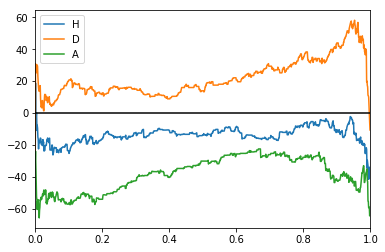

In [45]:
%matplotlib inline
p = abs_profits(models)
a  = p.plot()
_ = a.axhline(y=0, color='k')

If we would have followed our model and would only bet on the draw, then we would have made some profit.

But again, if we select the bets for a specific dataset, we should also investigate if maybe it would be 
better to also follow the bookmakers.

In [47]:
def follow_bookmakers(df):
    d = (df[df['odds-draw'] == df[['odds-home','odds-away','odds-draw']].max(axis=1)]['odds-draw'] * (df['result'] == 'D') -1).sum()
    h = (df[df['odds-home'] == df[['odds-home','odds-away','odds-draw']].max(axis=1)]['odds-home'] * (df['result'] == 'H') -1).sum()
    a = (df[df['odds-away'] == df[['odds-home','odds-away','odds-draw']].max(axis=1)]['odds-away'] * (df['result'] == 'A') -1).sum()
    return h, d, a

In [48]:
follow_bookmakers(df)

(37.11, 71.44, -205.17)

For this particular dataset, it would have made sense to follow the bookmakers for home and draw predictions.
But in general, our model does a better prediction as following the bookmakers.

Let's extend our datamodel to include all leagues.

# All leagues

In [49]:
df = pd.read_csv('all_processed.csv')

The odds over this particular dataset should be distributed more evenly.

In [51]:
follow_bookmakers(df)

(-128.97, -219.87000000000003, -1336.98)

Judging on this data, I would guess that our model will pick up the home matches first, followed by the draws.

Based on the huge loss of the away matches, these matches should be excluded from the model, unless some huge profit 
would be associated with the away matches

In [53]:
all_results, all_models = cross_validate(loss=odds_loss, output_classes=4, risk=1, batch_size=50, normalize=True, th2=0.99)

In [54]:
result = pd.concat({n: df for n, df in enumerate(all_results)},axis=0)
result.sum(level=1)

,Profit,Count,|Profit|,|Count|
home,-36.290012,1732.0,-3.750002,919.0
draw,-31.810005,348.0,-14.929999,77.0
away,0.000000,0.0,0.000000,0.0
no-bet,0.000000,0.0,0.000000,13543.0


In [55]:
p = abs_profits(all_models)

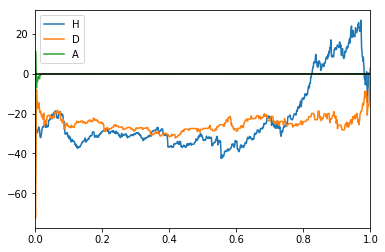

In [58]:
a  = p[0:].plot()
_ = a.axhline(y=0, color='k')

From a certain threshold, we make profit for the home teams, bot not for the draw matches.
Which should have been expected because of the nature of our dataset.

In [60]:
all_results, all_models = cross_validate(loss=darts_loss, output_classes=4, batch_size=50, normalize=True, th2=0.99)

In [64]:
result = pd.concat({n: df for n, df in enumerate(all_results)},axis=0)
result.sum(level=1)

,Profit,Count,|Profit|,|Count|
home,-247.239975,4874.0,-77.560005,2952.0
draw,-44.489998,1434.0,-44.109997,287.0
away,-105.050003,2452.0,-14.570005,734.0
no-bet,0.000000,0.0,0.000000,5981.0


In [65]:
p = abs_profits(all_models)

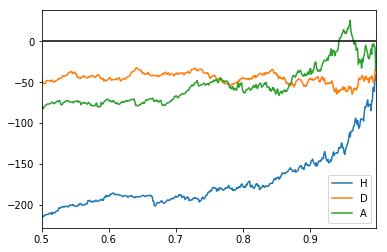

In [66]:
a  = p[0.5:].plot()
_ = a.axhline(y=0, color='k')

In [67]:
all_results, all_models = cross_validate(loss=darts_loss, batch_size=50, normalize=True, th2=0.99, activation="sigmoid")

In [68]:
p = abs_profits(all_models)

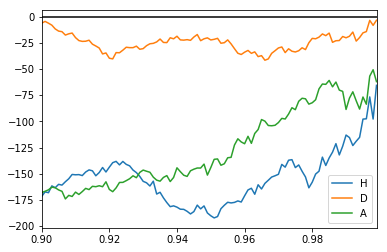

In [69]:
a  = p[0.9:].plot()
_ = a.axhline(y=0, color='k')

In [70]:
all_results, all_models = cross_validate(loss=odds_loss, output_classes=4, risk=1, batch_size=50, normalize=True, hidden_layer=[20,20], th2=0.99)

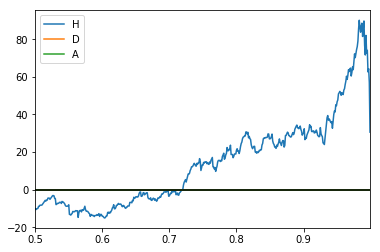

In [83]:
%matplotlib inline
p = abs_profits(all_models)
a  = p[0.5:].plot()
_ = a.axhline(y=0, color='k')

Finally we are making some profit, if we set the threshold for this model at 0.99.

In [85]:
probs = np.concatenate(all_models[1])
odds = np.concatenate(all_models[2])
sel = probs > 0.99
(probs * np.clip(odds-1,-1,np.inf))[sel[:,0]].sum(), sel[:,0].sum()

(89.68807741889958, 833)

In [86]:
89 / 833

0.10684273709483794

On the 833 bets placed, a profit of 89 is gained, which is a little bit more than 10%.
Not bad, but I have the feeling we need to look into hyperparameter optimization to
get an even higher profit.